In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from timeseries import *
from models import *
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
from fastai.distributed import *
import neptune
from neptunecontrib.monitoring.fastai import NeptuneMonitor

/opt/anaconda/envs/pytorch/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [3]:
x, y = pickle.load(open("data/train.pkl", "rb"))

In [4]:
test_name, x_test = pickle.load(open("data/test.pkl", "rb"))

In [5]:
x.mean(), x.std(), x.min(), x.max()

(-6.63823368281504e-06, 79.22496224741775, -5831.451171875, 6120.92822265625)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1)
bs = 32

In [8]:
data = (ItemLists(Path("data"), TSList(x_train),TSList(x_val))
        .label_from_lists(y_train, y_val)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data

TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,1
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,2
Path: .;

Test: None

In [9]:
data.train_ds.x[0].data.shape

torch.Size([12, 4096])

In [10]:
data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f341e9ee410>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x7f34a9c0c050>)

In [11]:
data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f341f2f5f90>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x7f34a9c0c050>)

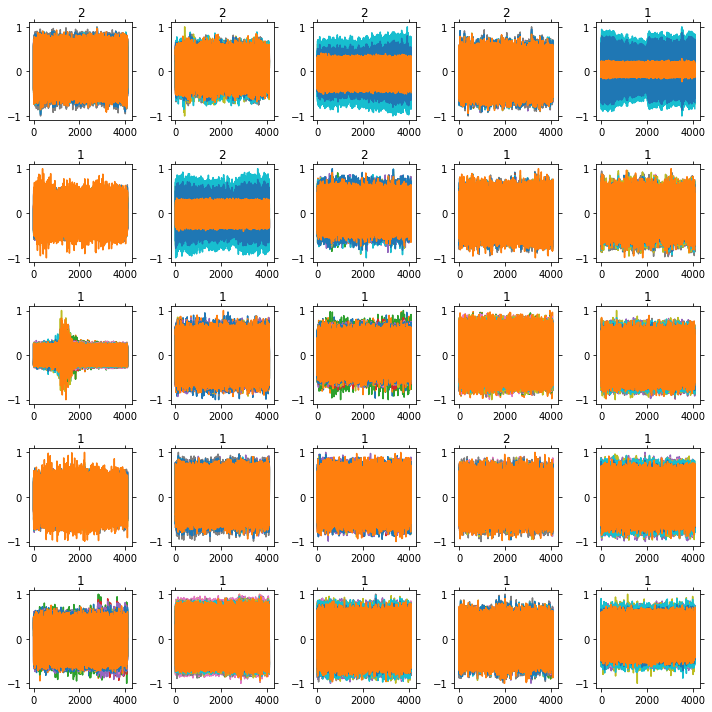

In [12]:
data.show_batch()

In [13]:
model = ResNet(data.features, data.c).to(device)
kappa = KappaScore()
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'ResNet simple')
learn = Learner(data, model, metrics=[accuracy, kappa])

https://ui.neptune.ml/andrijdavid/ClinicalBrainComputerInterfacesChallenge2020/e/CBCIC2020-367


epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.751110,0.702247,0.507812,0.000000,00:03
1,0.717466,0.691418,0.492188,-0.027161,00:02
2,0.697864,0.682067,0.570312,0.133432,00:02
3,0.681134,0.656812,0.601562,0.210068,00:02
4,0.671116,0.677678,0.562500,0.122644,00:02
5,0.666624,0.920279,0.515625,0.018065,00:02
6,0.671718,0.688042,0.523438,0.034619,00:02
7,0.659863,0.743354,0.554688,0.099259,00:02
8,0.645705,1.615366,0.523438,0.034142,00:02
9,0.630400,1.040378,0.648438,0.290291,00:02


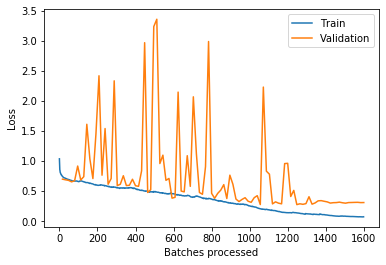

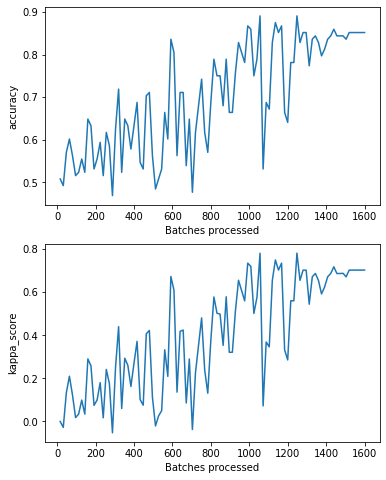

In [14]:
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.save("resnet-relu-step-1")
learn.export("resnet-relu-step-1.pkl")
neptune.log_artifact(f'data/resnet-relu-step-1.pkl') 
neptune.log_artifact(f'data/models/resnet-relu-step-1.pth')
neptune.stop()

In [ ]:
learn.destroy()

# Can we fit all the data in memory ?

In [14]:
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1)
bs = 256

In [15]:
data = (ItemLists(Path("data"), TSList(x_train),TSList(x_val))
        .label_from_lists(y_train, y_val)
        .databunch(bs=bs, val_bs=128)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data

TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,1
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,2
Path: .;

Test: None

In [16]:
model = ResNet(data.features, data.c).to(device)
kappa = KappaScore()
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'ResNet fp16')
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [17]:
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.820163,0.692990,0.507812,0.000000,00:03
1,0.774946,0.693227,0.492188,0.000000,00:01
2,0.748356,0.693543,0.492188,0.000000,00:01
3,0.731352,0.693595,0.492188,0.000000,00:01
4,0.721492,0.693377,0.421875,-0.150911,00:01
5,0.714086,0.693107,0.492188,-0.031235,00:01
6,0.707463,0.693003,0.500000,-0.008619,00:01
7,0.701380,0.694222,0.445312,-0.095996,00:01
8,0.694503,0.694688,0.492188,-0.002893,00:01
9,0.686541,0.696187,0.468750,-0.049433,00:01


In [18]:
learn.save("resnet")
learn.export("resnet")
neptune.log_artifact(f'data/resnet.pkl') 
neptune.log_artifact(f'data/models/resnet.pth')
neptune.stop()

In [19]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# ResNet with Weighted Pooling

In [20]:
model = ResNet(data.features, data.c, pool=WeightedAdataptivePooling1d).to(device)
kappa = KappaScore()
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'ResNet with weighted pooling fp16')
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [21]:
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.752847,0.692542,0.507812,0.000000,00:01
1,0.718642,0.692484,0.507812,0.000991,00:01
2,0.674211,0.692303,0.554688,0.100592,00:01
3,0.644823,0.692133,0.546875,0.085489,00:01
4,0.611518,0.692179,0.546875,0.090419,00:01
5,0.583966,0.692396,0.539062,0.082604,00:01
6,0.556736,0.691773,0.570312,0.136832,00:01
7,0.528554,0.691715,0.523438,0.034142,00:01
8,0.501769,0.691504,0.500000,-0.015621,00:01
9,0.474681,0.693465,0.507812,0.000000,00:01


In [ ]:
learn.save("resnetwp")
learn.export("resnetwp")
neptune.log_artifact(f'data/resnetwp.pkl') 
neptune.log_artifact(f'data/models/resnetwp.pth')
neptune.stop()
learn.destroy()

# ResNet with Simple Attention

In [22]:
model = ResNetSA(data.features, data.c).to(device)
kappa = KappaScore()
loss_func=LabelSmoothingCrossEntropy()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy, kappa])

In [23]:
# learn.fit_one_cycle(100)

# ResNet with Simple Attention and Temporal Attention

In [24]:
model = ResNetSA(data.features, data.c, temporal=True).to(device)
kappa = KappaScore()
loss_func=LabelSmoothingCrossEntropy()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy, kappa])

In [25]:
# learn.fit_one_cycle(100)

# ResNext

In [26]:
model = ResNeXt(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [27]:
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'ResNext')
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.699653,0.693311,0.492188,0.000000,00:02
1,0.684357,0.692944,0.554688,0.099259,00:02
2,0.672751,0.692838,0.507812,0.000000,00:02
3,0.660344,0.693001,0.507812,0.000000,00:02
4,0.647185,0.693756,0.507812,0.000000,00:02
5,0.634403,0.697617,0.507812,0.000000,00:02
6,0.618907,0.709475,0.507812,0.000000,00:02
7,0.604789,0.756427,0.507812,0.000000,00:02
8,0.595711,0.852650,0.507812,0.000000,00:02
9,0.583796,1.017536,0.507812,0.000000,00:02


In [ ]:
learn.save("resnext")
learn.export("resnext")
neptune.log_artifact(f'data/resnext.pkl') 
neptune.log_artifact(f'data/models/resnext.pth')
neptune.stop()
learn.destroy()

# ResNext WAD

In [29]:
model = ResNeXt(data.features, data.c, pool=WeightedAdataptivePooling1d).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [30]:
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'ResNext weighted adaptive Pooling')
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,1.975695,0.693734,0.492188,0.000000,00:02
1,1.425890,0.695174,0.492188,0.000000,00:02
2,1.234308,0.700390,0.492188,0.000000,00:03
3,1.087925,0.706525,0.492188,0.000000,00:03
4,0.983937,0.709911,0.492188,0.000000,00:03
5,0.909281,0.709296,0.492188,0.000000,00:03
6,0.833481,0.706631,0.492188,0.000000,00:02
7,0.774863,0.702255,0.492188,0.000000,00:02
8,0.721455,0.698764,0.492188,0.000000,00:02
9,0.669749,0.695888,0.476562,-0.031761,00:02


In [ ]:
learn.save("resnextwd")
learn.export("resnextwd")
neptune.log_artifact(f'data/resnextwd.pkl') 
neptune.log_artifact(f'data/models/resnextwd.pth')
neptune.stop()
learn.destroy()

# InceptionTime

In [31]:
model = InceptionTime(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [32]:
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'InceptionTime')
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.714809,0.693984,0.507812,0.000000,00:01
1,0.705855,0.693992,0.507812,0.000000,00:01
2,0.699263,0.693896,0.507812,0.000000,00:01
3,0.692006,0.693781,0.507812,0.000000,00:01
4,0.686037,0.693744,0.507812,0.000000,00:01
5,0.681029,0.693817,0.507812,0.000000,00:01
6,0.675045,0.693867,0.507812,0.000000,00:01
7,0.669252,0.694001,0.507812,0.000000,00:01
8,0.666134,0.694392,0.507812,0.000000,00:01
9,0.663836,0.694424,0.507812,0.000000,00:01


In [33]:
learn.save("inception")
learn.export("incpetion")
neptune.log_artifact(f'data/inception.pkl') 
neptune.log_artifact(f'data/models/inception.pth')
neptune.stop()
learn.destroy()

# ResCNN

In [35]:
model = ResCNN(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [36]:
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'ResCNN')
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.793387,0.693121,0.507812,0.000000,00:01
1,0.782850,0.693189,0.492188,-0.003861,00:01
2,0.773822,0.693445,0.492188,0.000000,00:01
3,0.764631,0.693840,0.492188,0.000000,00:01
4,0.755540,0.694082,0.492188,0.000000,00:01
5,0.746010,0.694318,0.492188,0.000000,00:01
6,0.737005,0.694959,0.492188,0.000000,00:01
7,0.727948,0.695313,0.492188,0.000000,00:01
8,0.720347,0.694781,0.507812,0.027965,00:01
9,0.712340,0.692560,0.570312,0.143135,00:01


In [37]:
learn.save("rescnn")
learn.export("rescnn")
neptune.log_artifact(f'data/rescnn.pkl') 
neptune.log_artifact(f'data/models/rescnn.pth')
neptune.stop()
learn.destroy()

# FCN

In [39]:
model = FCN(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [40]:
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'FCN')
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.709862,0.694330,0.492188,0.000000,00:01
1,0.704178,0.694798,0.492188,0.000000,00:01
2,0.700660,0.695512,0.492188,0.000000,00:01
3,0.697008,0.696638,0.492188,0.000000,00:01
4,0.694794,0.697570,0.492188,0.000000,00:01
5,0.691592,0.696943,0.492188,-0.001444,00:01
6,0.689435,0.696448,0.445312,-0.095996,00:01
7,0.687391,0.698320,0.445312,-0.096525,00:01
8,0.685641,0.699022,0.476562,-0.037252,00:01
9,0.683590,0.695493,0.500000,0.004133,00:01


In [41]:
learn.save("fcn")
learn.export("fcn")
neptune.log_artifact(f'data/fcn.pkl') 
neptune.log_artifact(f'data/models/fcn.pth')
neptune.stop()
learn.destroy()

# Wide ResNet

In [43]:
model = WideResNet(n_in_channels=data.features, num_classes=data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [44]:
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'Wide ResNet')
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.693978,0.693017,0.507812,0.027496,00:01
1,0.694016,0.693009,0.500000,0.012774,00:01
2,0.693950,0.692981,0.500000,0.012774,00:01
3,0.693902,0.692920,0.500000,0.012774,00:01
4,0.693875,0.692859,0.500000,0.012774,00:01
5,0.693837,0.692789,0.500000,0.012298,00:01
6,0.693784,0.692723,0.500000,0.011821,00:01
7,0.693729,0.692673,0.515625,0.041314,00:01
8,0.693651,0.692631,0.492188,-0.006776,00:01
9,0.693587,0.692603,0.492188,-0.009709,00:01


In [ ]:
learn.save("wideresnet")
learn.export("wideresnet")
neptune.log_artifact(f'data/wideresnet.pkl') 
neptune.log_artifact(f'data/models/wideresnet.pth')
neptune.stop()
learn.destroy()

# Wide ResNet22

In [45]:
model = WideResNet(n_in_channels=data.features, num_classes=data.c, num_groups=3, N=3, k=6, drop_p=0.).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [46]:
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'Wide ResNet22')
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.704373,0.692916,0.539062,0.069492,00:02
1,0.698297,0.693079,0.507812,0.000000,00:02
2,0.693405,0.692992,0.507812,0.000000,00:02
3,0.689065,0.693028,0.500000,-0.015621,00:02
4,0.684884,0.693119,0.507812,0.001486,00:02
5,0.680400,0.692972,0.507812,0.001486,00:02
6,0.675965,0.692099,0.500000,-0.013109,00:02
7,0.670748,0.690292,0.515625,0.018551,00:02
8,0.665198,0.684566,0.523438,0.035573,00:02
9,0.659263,0.677577,0.539062,0.067194,00:02


In [ ]:
learn.save("wideresnet22")
learn.export("wideresnet22")
neptune.log_artifact(f'data/wideresnet22.pkl') 
neptune.log_artifact(f'data/models/wideresnet22.pth')
neptune.stop()
learn.destroy()

# Xception

In [47]:
model = xception(data.c, in_channels=data.features).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [48]:
neptune.init(project_qualified_name='andrijdavid/ClinicalBrainComputerInterfacesChallenge2020')
neptune.create_experiment(name=f'Xception')
learn.fit_one_cycle(100, callbacks=[NeptuneMonitor()])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.757142,0.693597,0.492188,0.000000,00:01
1,0.695077,0.693577,0.492188,0.000000,00:01
2,0.666656,0.693767,0.492188,0.000000,00:01
3,0.644065,0.694720,0.492188,0.000000,00:01
4,0.612924,0.697821,0.492188,0.000000,00:01
5,0.573940,0.712661,0.492188,0.000000,00:01
6,0.537144,0.747558,0.492188,0.000000,00:01
7,0.512039,0.729416,0.492188,0.000000,00:01
8,0.563485,0.824681,0.492188,0.000000,00:01
9,0.550062,0.819955,0.492188,0.000000,00:01


In [ ]:
learn.save("xception")
learn.export("xception")
neptune.log_artifact(f'data/xception.pkl') 
neptune.log_artifact(f'data/models/xception.pth')
neptune.stop()
learn.destroy()

# Rocket

## Normalize data 'per sample'

In [49]:
eps = 1e-6
x_train = (x_train - x_train.mean(axis=(1, 2), keepdims=True)) / ( x_train.std(axis=(1, 2), keepdims=True) + eps)
x_val = (x_val - x_val.mean(axis=(1, 2), keepdims=True)) / ( x_val.std(axis=(1, 2), keepdims=True) + eps)

In [50]:
x_train.shape

(512, 12, 4096)

## calculate features

In [51]:
_, features, seq_len = x_train.shape
model = ROCKET(features, seq_len, n_kernels=10000, kss=[7, 9, 11]).to(device)
x_train_tfm = model(torch.tensor(x_train, device=device).float())
x_valid_tfm = model(torch.tensor(x_val, device=device).float())

In [52]:
x_train_tfm.shape

torch.Size([512, 20000])

## Normalize 'per feature'

In [53]:
f_mean = x_train_tfm.mean(dim=0, keepdims=True)
f_std = x_train_tfm.std(dim=0, keepdims=True) + eps
x_train_tfm_norm = (x_train_tfm - f_mean) / f_std
x_valid_tfm_norm = (x_valid_tfm - f_mean) / f_std

In [54]:
data = (ItemLists('.', TSList(x_train_tfm_norm), TSList(x_valid_tfm_norm))
        .label_from_lists(y_train, y_val)
        .databunch(bs=64, val_bs=min(bs * 2, len(x_val)))
       )
data

TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000)
y: CategoryList
1,2,2,2,1
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000)
y: CategoryList
1,2,2,2,2
Path: .;

Test: None

In [55]:
model = ResNet(data.features, data.c).to(device)
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.762077,0.698415,0.507812,0.000000,00:04
1,0.738201,0.699824,0.468750,-0.052479,00:04
2,0.724262,0.700020,0.460938,-0.068732,00:03
3,0.715176,0.703671,0.500000,0.012298,00:03
4,0.708836,0.710942,0.546875,0.104031,00:03
5,0.704917,0.687689,0.593750,0.193212,00:03
6,0.701661,0.686329,0.585938,0.180676,00:03
7,0.699458,0.721611,0.554688,0.114563,00:03
8,0.696583,0.705803,0.554688,0.117988,00:03
9,0.697492,0.705326,0.609375,0.225369,00:03


In [56]:
learn.save("resnet-rocket")

In [57]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
